In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MSMRD as mrd
from MSMRD.trajectories import allTrajs
import pickle
import h5py
import math
%matplotlib inline

In [2]:
nFiles = 16
fName = '../data/asym2D/2DasymTrajsLong_smallR_bigT_'
dimension = 2
trajs = []
for number in range(nFiles):
    f = h5py.File(fName + str(number) + '.h5', 'r')
    data = np.array(f['traj'][::10,...], dtype=float)
    traj = data[::5,1:dimension+1]
    trajs.append(traj)
    f.close()

In [2]:
# Create a child class from the main class in trajectories_class.py
class asym2Dtraj(allTrajs):
    def __init__(self, centers=None, Trajs=None):
        super(asym2Dtraj, self).__init__(Trajs)
        if centers == None:
            centers = []
        self.centers = centers
        self.bathRad = 3.0
        self.innerMSMrad = 2.0
        self.Ncenters = len(self.centers)
    
    # Overwrite getState function in parent class
    #discretize trajectory: use two additional rings of states for entry and exit states
    #cluster volume should be on the same order of magnitute as for the internal states
    def getState(self, coord, prevst):
        radius = np.linalg.norm(coord)
        # inner MSM
        if radius < self.innerMSMrad:
            cen2coord = self.centers - coord
            norm = np.linalg.norm(cen2coord, axis = 1)
            index = np.argmin(norm)
            if (norm[index] <= 0.2 ):
                return index
            # if no new state found, return previous state
            return prevst
        # Bath state
        elif radius > self.bathRad:
            return self.Ncenters
        else:
            return prevst
    
        
    # Overwrite getMilestones function
    def getMilestones(self):
        int_th = 2*np.pi/self.angularPartitions
        # inner MSM
        for i in range(self.Ncenters):
            self.milestones[i] = self.centers[i]
        # entry states
        for i in range(self.angularPartitions):
            j = i + self.Ncenters;
            r = 0.5*(self.innerMSMrad + self.entryRad)
            th = i*int_th + 0.5*int_th
            self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
        # exit states
        for i in range(self.angularPartitions):
            j = i + self.Ncenters + self.angularPartitions;
            r = 0.5*(self.entryRad + self.bathRad)
            th = i*int_th + 0.5*int_th
            self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
                # entry states
        for i in range(self.angularPartitions):
            j = i + self.Ncenters + 2*self.angularPartitions;
            r = 0.5*(self.bathRad + self.bathRadOut)
            th = i*int_th + 0.5*int_th
            self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
        
    
    # Overwrite getRegionMap function
    def getRegionMap(self):
        for i in range(self.Ncenters):
            statename = 'Inner state ' + str(i)
            self.regionMap[i] = statename
        for i in range(self.angularPartitions):
            statename = 'Entry state ' + str(i)
            j = self.Ncenters + i
            self.regionMap[j] = statename
        for i in range(self.angularPartitions):
            statename = 'Exit state ' + str(i)
            j = self.Ncenters + self.angularPartitions + i
            self.regionMap[j] = statename
        for i in range(self.angularPartitions):
            statename = 'Bath state ' + str(i)
            j = self.Ncenters + 2*self.angularPartitions + i
            self.regionMap[j] = statename


In [3]:
numfiles = 16
# Extract trajectories from file using asym2Dtraj class
fname = '../data/asym2D/2DasymTrajsLong_smallR_bigT_'
minima = [[0.0,0.0], [1.0,0.0] , [1.1, 1.0], [-0.1,0.9], [-1.3,0.8], \
                       [-1.0,-0.2], [-0.6,-1.0], [0.9,-0.8], [0.2,-1.5]]
alltrajs = asym2Dtraj(minima, []) # define allTrajs object
#alltrajs = allTrajs_inner([])
dimension = 2
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    traj = data[::5,1:dimension+1]
    alltrajs.Trajs.append(traj)

In [4]:
# Calculate discrete trajectories and make sure it is clean (no "None" elements)
dtrajs = alltrajs.getdTrajsclean()

In [9]:
class asym2Dmilestoning(object):
    def __init__(self, centers, bathRadius):
        self.centers = centers
        self.bathRadius = bathRadius
        #the index of the bath state is given by the number of centers 
        self.bathIndex = len(centers)
        #total number of states is Ncenters (in this case there is no bath state)
        self.Nstates = self.bathIndex
        self.innerMSMrad = np.max(np.linalg.norm(self.centers, axis=1))+0.2
        self.transitionProbs = []
        
    #compute transition times from a list of trajectories
    def computeMeanTransitionTimes(self, timestep, dTrajs):
        sumTau = np.zeros((self.Nstates, self.Nstates))
        counts = np.zeros((self.Nstates, self.Nstates))
        for dTraj in self.dTrajs:
            i = 0
            tau = 0
            statesVisited = [dTraj[0]]
            while i<len(dTraj):
                i += 1
                if dTraj[i] == dTraj[i-1]:
                    tau += 1
                else:
                    if not np.in1d(dTraj[i], statesVisited):
                        sumTau[transitionFrom, dTraj[i]] += tau
                        counts[transitionFrom, dTraj[i]] += 1
                        if nextTransitionIndex < 0:
                            nextTransitionIndex = i
                        statesVisited.appen(dTraj[i])
                        tau +=1
                    else:
                        statesVisited = [dTraj[nextTransitionIndex]]
                        i = nextTransitionIndex
                        nextTransitionIndex = -1
                        tau = 0
        for i in range(0, self.Nstates):
            for j in range(0, self.Nstates):
                if counts[i,j] != 0:
                    self.meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
        '''
        for dTraj in self.dTrajs:
            tau = 0
            statesVisited = []
            for i in range(len(dTraj)):
                if dTraj[i] == dTraj[i-1]:
                    tau += 1
                else:
                    sumTau[dTraj[i-1], dTraj[i]] += tau
                    nextTransitionIndex = i
                    counts[dTraj[i-1], dTraj[i]] += 1
                    
                    
                    tau = 0
        nonzeros = np.where(counts!=0)[0]
        self.meanTransitionTimes = np.zeros_like(counts)
        '''


    def getState(self, coord, prevst):
        radius = np.linalg.norm(coord)
        # inner MSM
        if radius < self.innerMSMrad:
            cen2coord = self.centers - coord
            norm = np.linalg.norm(cen2coord, axis = 1)
            index = np.argmin(norm)
            if (norm[index] <= 0.2 ):
                return index
            # if no new state found, return previous state
            else:
                return prevst
        # bath state
        elif radius > self.bathRadius:
            return self.bathIndex
        else: 
            return prevst
        
    def computeMilestoningTraj(self, trajs):
        self.dTrajs = []
        for traj in trajs:
            dTraj = np.zeros(len(traj))
            dTraj[0] = 0
            for i in range(1, len(traj)):
                dTraj[i] = self.getState(traj[i], dTraj[i-1])
                if math.isnan(dTraj[i]):
                    print dTraj[i-1]
                    print traj[i]
                    print self.centers - traj[i]
                    print np.linalg.norm(self.centers - traj[i], axis = 1)
                    print np.argmin( np.linalg.norm(self.centers - traj[i], axis = 1))
            self.dTrajs.append(dTraj)

In [10]:
def computeMeanTransitionTimes(timestep, mobj):
    sumTau = np.zeros((mobj.Nstates, mobj.Nstates))
    counts = np.zeros((mobj.Nstates, mobj.Nstates))
    for dTraj in mobj.dTrajs:
        i = 1
        tau = 1
        statesVisited = [dTraj[0]]
        transitionFrom = dTraj[0]
        nextTransitionIndex = -1
        while i<len(dTraj)-1:
            i += 1
            if dTraj[i] == dTraj[i-1]:
                tau += 1
            else:
                if len(statesVisited) == mobj.Nstates:
                    transitionFrom = dTraj[nextTransitionIndex]
                    statesVisited = [transitionFrom]
                    i = nextTransitionIndex
                    nextTransitionIndex = -1
                    tau = 1 
                elif not np.in1d(dTraj[i], statesVisited):
                    sumTau[transitionFrom, dTraj[i]] += tau
                    counts[transitionFrom, dTraj[i]] += 1
                    if nextTransitionIndex < 0:
                        nextTransitionIndex = i
                    statesVisited.append(dTraj[i])
                    tau +=1
                else:
                    tau += 1
    meanTransitionTimes = np.zeros((mobj.Nstates, mobj.Nstates))
    for i in range(0, mobj.Nstates):
        for j in range(0, mobj.Nstates):
            if counts[i,j] != 0:
                meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
    return meanTransitionTimes

In [11]:
minima = [[0.0,0.0], [1.0,0.0] , [1.1, 1.0], [-0.1,0.9], [-1.3,0.8], [-1.0,-0.2], [-0.6,-1.0], [0.9,-0.8], [0.2,-1.5]]
milestoning = asym2Dmilestoning(minima, 3.0)
milestoning.computeMilestoningTraj(trajs)

In [12]:
MTT = computeMeanTransitionTimes(0.01, milestoning)

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


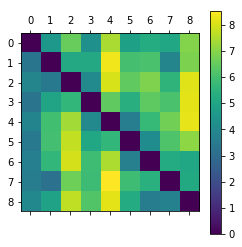

In [13]:
plt.matshow(MTT)
plt.colorbar()
#plt.clim((0., 9.0))

In [14]:
import pickle
pickle.dump(MTT, open('2DasymMTT_inner.p', 'wa'))

In [72]:
print minima[2]
print minima[6]

[1.1, 1.0]
[-0.6, -1.0]


In [74]:
milestoning.meanTransitionTimes[6,2]

0.0